<a href="https://colab.research.google.com/github/krishna-py/dl-projects/blob/main/CatsvsDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install tensorflow_data_validation

# Cats vs Dogs. Benchmarking multiple CNN backbone architectures.

Using Cats vs Dogs dataset, we want to establish which Model works best Top-1, Top-5 accuracy, F1-score and fastest model for inference, using TFLite.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

## Importing and Analyzing the dataset

In [3]:
(train_ds, test_ds), ds_info = tfds.load("cats_vs_dogs", split=['train[:80%]','train[80%:]'], shuffle_files=True, as_supervised=True, with_info=True,)
print(train_ds, test_ds)
print(ds_info)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)> <_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits

### Analyzing the class distribution in train and test datasets

In [4]:
# Calculate the class distribution in each dataset
train_labels = [label for _, label in train_ds.take(-1)]
test_labels = [label for _, label in test_ds.take(-1)]

In [5]:
print(f'Train dataset[{len(train_labels)}]: Cats[{len(train_labels)-np.count_nonzero(train_labels)}] vs Dogs[{np.count_nonzero(train_labels)}]')
print(f'Test dataset[{len(test_labels)}]: Cats[{len(test_labels)-np.count_nonzero(test_labels)}] vs Dogs[{np.count_nonzero(test_labels)}]')

Train dataset[18610]: Cats[9378] vs Dogs[9232]
Test dataset[4652]: Cats[2280] vs Dogs[2372]


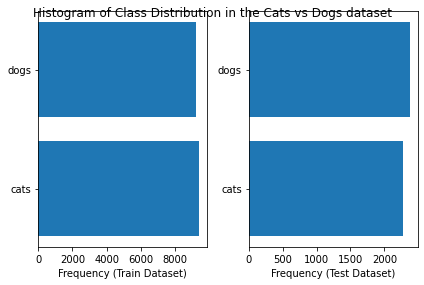

In [6]:
labels = ['cats', 'dogs']
ypos = np.arange(len(labels))
train_count = [len(train_labels)-np.count_nonzero(train_labels), np.count_nonzero(train_labels)]
test_counts = [len(test_labels)-np.count_nonzero(test_labels), np.count_nonzero(test_labels)]
plt.figure()
plt.suptitle('Histogram of Class Distribution in the Cats vs Dogs dataset')
plt.subplot(1,2,1)
plt.barh(ypos, train_count)
plt.yticks(ypos, labels)
plt.xlabel('Frequency (Train Dataset)')
plt.subplot(1,2,2)
plt.yticks(ypos, labels)
plt.barh(ypos, test_counts)
plt.xlabel('Frequency (Test Dataset)')
plt.tight_layout()
plt.show()

### Visualizing Train Dataset

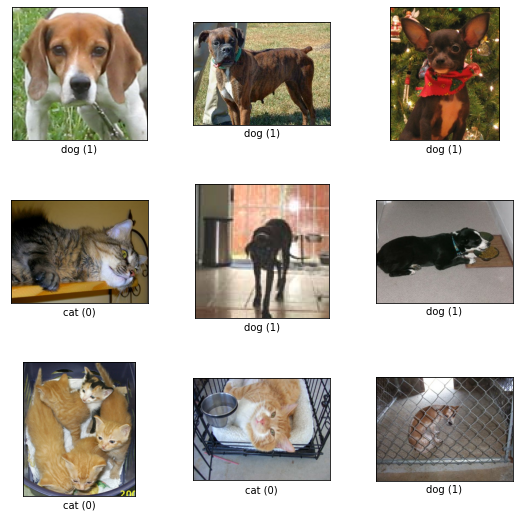

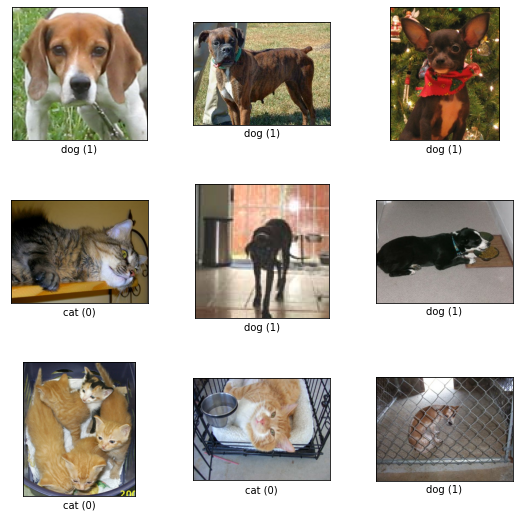

In [7]:
tfds.show_examples(train_ds, ds_info)

### Visualizing Test Dataset

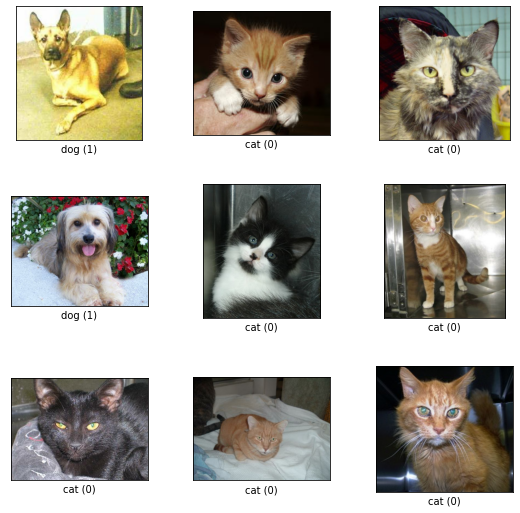

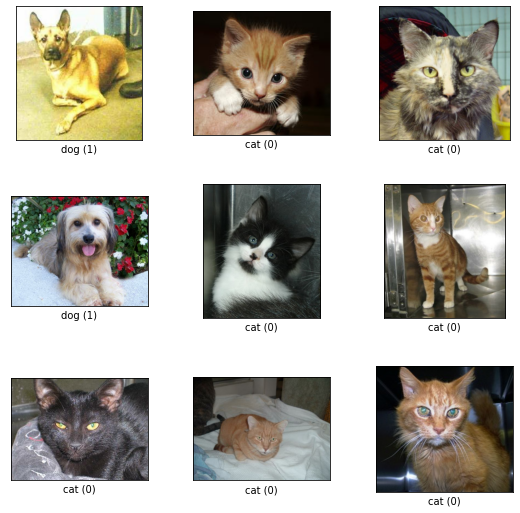

In [8]:
tfds.show_examples(test_ds, ds_info)

## Demonstrating Image Recognition using the Resnet50 network as baseline.
### Preprocess and prepare the datasets

In [9]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input
IMG_HEIGHT, IMG_WIDTH = 150, 150

In [10]:
def resize_img(image, label):
  image = tf.image.resize_with_crop_or_pad(image, target_height=IMG_HEIGHT, target_width=IMG_WIDTH)
  return image, label

In [11]:
train_ds = train_ds.map(resize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(len(train_labels))
train_ds = train_ds.batch(128)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
test_ds = test_ds.map(resize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(128)
test_ds = test_ds.cache()
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
print(train_ds)

<PrefetchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.uint8, tf.int64)>


### Random Data Augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
                                         tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
                                         tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
                                         tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2, 0.2)),
])

### Import and setup the Resnet50v2 model

In [15]:
base_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=(IMG_HEIGHT,IMG_WIDTH,3))
base_model.trainable = False

In [16]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3), name='input')
x = data_augmentation(inputs)
x = tf.keras.layers.Lambda(lambda img: preprocess_input(img))(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, name='output')(x)
model = tf.keras.Model(inputs, outputs, name='CatsVsDogs_Resnet50v2_150x150')
model.summary()

Model: "CatsVsDogs_Resnet50v2_150x150"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
lambda (Lambda)              (None, 150, 150, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
output (Dense)               (None, 1

### Train the Top layer

In [17]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [ ]:
epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=test_ds)

Epoch 1/20
146/146 [==============================] - 1542s 10s/step - loss: 0.2638 - binary_accuracy: 0.8817 - val_loss: 0.1199 - val_binary_accuracy: 0.9482
Epoch 2/20
146/146 [==============================] - 1511s 10s/step - loss: 0.1713 - binary_accuracy: 0.9241 - val_loss: 0.1114 - val_binary_accuracy: 0.9570
Epoch 3/20
146/146 [==============================] - 1511s 10s/step - loss: 0.1499 - binary_accuracy: 0.9362 - val_loss: 0.1064 - val_binary_accuracy: 0.9594
Epoch 4/20
146/146 [==============================] - 1510s 10s/step - loss: 0.1509 - binary_accuracy: 0.9332 - val_loss: 0.1006 - val_binary_accuracy: 0.9589
Epoch 5/20
 11/146 [=>............................] - ETA: 18:53 - loss: 0.1482 - binary_accuracy: 0.9332

### Finetune the Resnet model another 10 epochs


In [ ]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)